In [1]:
# Распред обручей
import pandas as pd
import numpy as np
import random

shops = pd.read_excel('C:\анаконда\shop_list.xlsx', dtype='int')
                     
# достаем Тпг+размер c количеством которые нужно считать из накладной 
tmp_df = pd.read_excel('C:/рушники/123.xlsx', dtype='str')
tmp_df['tpg'] = tmp_df['Товарная подгруппа'].str.cat(tmp_df['Размер'], sep="_")

#del tmp_df['№ Поставщика']
tmp_df['tpg'] = tmp_df['tpg'].str.replace('.', ',')# меняем точки на запятые
tmp_df.sort_values(by=['tpg'], inplace=True)
tpg = tmp_df['tpg'].unique().tolist()
tpg.sort()
tpg_dic = tmp_df['tpg'].value_counts().to_dict()

# Загружаем нормы и остатки по нужным тпг чтобы посчитать дефицит
n_link =  r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\Отдел закупки\ЛИЧНЫЕ\Семен\нужное\матрица обручей.xlsx'
norms = pd.read_excel(n_link, sheet_name='гладкая_плоская размеры_тпг', skiprows=3, usecols=['номер', *tpg]) 
stock = pd.read_excel(r'C:\Остатки\Обручальные кольца.xlsx', usecols=['КодСклада','ТоварнаяПодгруппа','РазмерИзделия'], dtype='str')
stock.columns = ['КодСклада', 'Товарная подгруппа', 'Размер']
stock['Размер'] = stock['Размер'].str.replace('.', ',')
stock['tpg'] = stock['Товарная подгруппа'].str.cat(stock['Размер'], sep="_")
stock.drop(columns=['Товарная подгруппа','Размер'], inplace=True)
stock = stock[stock['tpg'].isin(tpg)]
stock = stock.groupby(by=['КодСклада', 'tpg'])['tpg'].aggregate('count').unstack(fill_value=0.0)
stock.reset_index(inplace=True)
stock = stock.astype('int')
stock.columns.values[0] = 'номер'
stock = stock[norms.columns.tolist()]
norms = shops.merge(norms, on='номер', how='left')
stock = shops.merge(stock, on='номер', how='left').fillna(0)
norms.set_index('номер', inplace=True)
stock.set_index('номер', inplace=True)

norms = norms.applymap(lambda x: round(x * 1.3))# для распреда того что не входит

demand = norms - stock
demand = demand.applymap(lambda num: 0 if num < 0 else num)

def raspred_dict(df):
    emp = []
    cols = df.columns.tolist()
    for col in cols:
        emp.append(list(np.repeat(df.index.to_numpy(),df[col].values.astype(int))))
    return dict(zip(cols, emp))

no7171_dict = raspred_dict(demand)

def dictu(x):    
    if tpg_dic[x] > len(no7171_dict[x]):
        over = tpg_dic[x] - len(no7171_dict[x])
        no7171_dict[x] = [*no7171_dict[x], *([7171] * over)]        
    elif tpg_dic[x] < len(no7171_dict[x]):
        no7171_dict[x] = no7171_dict[x][:tpg_dic[x]]        
    return no7171_dict[x]

lst = [dictu(x) for x in tpg]

tmp_df['Период реализации'] = np.array([item for sublist in lst for item in sublist])
name = 'C:/рушники/' + str(random.randrange(5000,10000)) + '.xlsx'
tmp_df.to_excel(name, sheet_name='Движение товара', index=False)

In [ ]:
#delete files
import os
path = 'C:/рушники/соединить'
dir_lst = os.listdir(path)
for x in dir_lst:
    os.remove(path + '/' + x)

In [16]:
# join files in folder
import os
import pandas as pd

path = 'C:/рушники/соединить'
  
files = [path + '/' + x for x in os.listdir(path)]
all_files = pd.concat([pd.read_excel(x) for x in files])
all_files.to_excel(path + '/all.xlsx', sheet_name='Движение товара', index=False)

In [49]:
# Распред букв или зодиаков по одному направлению
import pandas as pd
import numpy as np
import random

# get stockdata, goods receipt, shops list, stock capability
prih = pd.read_excel('C:/рушники/ИФ ЗОДИАК.xlsx')
prih.sort_values(by=['Товар'], inplace=True)
prih['Описание 3'] = prih['Описание 3'].str.lower()

letters = prih['Описание 3'].unique().tolist()
tovs = prih['Товар'].unique().tolist()
tovs.sort()

stock = pd.read_excel('C:/Остатки/Буквы и Зодиаки.xlsx')
stock = stock[stock['ТоварНо'].isin(tovs)]
stock.rename(columns={'Описание3': 'Описание 3'}, inplace=True)
stock['Описание 3'] = stock['Описание 3'].str.lower()

#create automatic demand calculation here
#norms = pd.read_excel('C:/Остатки/norm_bz.xlsx', sheet_name='norm_z', index_col= 'Название из NAV', usecols=['Название из NAV', 'sum_bk'])
#norm_dict = norms.sum_bk.apply(lambda x: round(x/12)).to_dict()

#estimate sheetname and filename for demand
tn = prih.loc[1, 'Товарное направление'].lower()
fname = 'C:/Остатки/' + prih.loc[1, 'Дизайн'][3:].lower() + '.xlsx'

demand = pd.read_excel(fname, sheet_name=tn, skiprows=1, usecols=['Наполняха', 'Код', *letters], index_col='Код')


#Create two dictionaries tov dict and letter dict
stock_dict = dict(zip(tovs,[stock[stock['ТоварНо'] == tov]['КодСклада'].tolist() for tov in tovs]))
df = prih.groupby(by=[ 'Товар', 'Описание 3'])['Товар'].count().rename('count')
df = df.reset_index()

tov_dict = dict(zip(df.Товар.tolist(), df[['Описание 3', 'count']].values.tolist())) #(tov:[letter, demand])

#letter: dataframe with columns:store number, filling rate, demand(positive num is overstock, negative num is demand)
letter_dict = dict(zip(letters,[demand[['Наполняха', letter]] for letter in letters]))

def get_shoplist(tov):
    """Get sorted by letter demand and stock list of stores with zero stock of tov.
    Changes letter dict according to this list. Two dictionaries needed to perform func"""
    
    letter = tov_dict[tov][0]
    lenth = tov_dict[tov][1]
    shoplist_full = letter_dict[letter].sort_values(by=[letter, 'Наполняха']).index.tolist()
    shoplist = [i for i in shoplist_full if i not in stock_dict[tov]]
    shop_len = len(shoplist)
    
    if shop_len > lenth:
        shoplist = shoplist[:lenth]
    elif len(shoplist) < lenth:
        over = lenth - shop_len
        shoplist = [*shoplist,*([7171] * over)]
    for shop in shoplist:
        if shop != 7171:
            letter_dict[letter][letter][shop] += 1
    return shoplist
      
lst = [get_shoplist(x) for x in tovs]
prih['Период реализации'] = np.array([item for sublist in lst for item in sublist])

name = 'C:/рушники/' + str(random.randrange(5000,10000)) + '.xlsx'
prih.to_excel(name, sheet_name='Движение товара', index=False)
    

C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
# Распред по товам по две три штуки в шоплист вторым столбцом указать количество столбец "кол"
import pandas as pd
import numpy as np
import random

# create distribution quantities dictionary
invoice = pd.read_excel('C:/рушники/БК.xlsx')
invoice.sort_values(by=['Товар'], inplace=True)
arts_dic = invoice['Товар'].value_counts().to_dict()

# create norms dataframe
shops = pd.read_excel('C:\анаконда\shop_list_doubled.xlsx', dtype='int')
shops.sort_values(by='кол',ascending=False, inplace=True)

num_dict = shops.кол.value_counts().sort_index(ascending=False).to_dict()
cols = list(invoice['Товар'].unique())

norms = pd.concat(
[pd.DataFrame(
    data=np.full((num_dict[i], len(cols)), i), 
    columns=cols)
 for i in list(num_dict)]
)  

norms.index = shops['номер']

# create stock df identical in shape to norms df
stock = pd.read_excel(r'C:\Остатки\Товы.xlsx', usecols=['КодСклада','ТоварНо'])
stock = stock[stock['КодСклада'].isin(norms.index.tolist()) & 
              stock['ТоварНо'].isin(cols)]

pivot = pd.pivot_table(stock,index='КодСклада', columns='ТоварНо', aggfunc=len, fill_value=0).reset_index()

stock = pd.DataFrame(data=shops['номер'].values, columns=['КодСклада']).merge(pivot, how='left')
stock.set_index('КодСклада',inplace=True)
stock.fillna(0, inplace=True)

if cols != stock.columns.to_list():
    add_cols = [x for x in cols if x not in stock.columns.to_list()]
    add_df = pd.DataFrame(data=np.zeros((stock.shape[0], len(add_cols))), columns=add_cols, index=stock.index)
    stock.join(add_df)
    
stock = stock[cols]

# demand 
demand = norms - stock

# distribution
def repeat_series(series):
    return np.repeat(series.index, series.values).tolist()

empty = []
for col in demand.columns.tolist():
    shop_lst = repeat_series(demand[col].loc[lambda x: x > 0])
    diff = arts_dic[col] - len(shop_lst)
    if diff > 0:
        shop_lst.extend(list(np.full(diff, 7171)))
    else:
        shop_lst = shop_lst[:arts_dic[col]]
    empty.extend(shop_lst)

invoice['Период реализации'] = empty

# save and exit
name = 'C:/рушники/' + str(random.randrange(5000,10000)) + '.xlsx'
invoice.to_excel(name, sheet_name='Движение товара', index=False)

In [69]:
sum(invoice['Период реализации'] == 7171)


383

In [5]:
import pandas as pd
pd.read_csv(r'C:\анаконда\tmp.csv', delimiter=';', 
                   encoding='utf-8', nrows=1).columns

Index(['КодСклада', 'НазваниеСклада', 'ТоварНо', 'СерийныйНомер', 'Тип1',
       'Тип2', 'Тип3', 'Дизайн', 'Производитель', 'Поставщик', 'ПоставщикАрт',
       'ШК', 'Датазакупки', 'КолВо', 'Вес', 'ЧистыйВес', 'Проба1',
       'РазмерИзделия', 'ВставкаКамней', 'ТолщинаПлетения', 'КолвоКамней',
       'СуммаРеализации', 'СуммаПрихода', 'ДатаПартии', 'ДатаПрихода',
       'ДатаВТорг', 'ОписаниеТовара', 'ГруппаНаценки', 'ТипИзделия',
       'СкидкаПоШК', 'СкидакаПоГруппе', 'СкидкаЗапрещена', 'ТоварнаяПодгруппа',
       'ПереоцененнаяСтоимость', 'ТоварноеНаправление', 'Картинка', 'Проект',
       'Номердокументазакупки', 'ЛогистическийПризнак', 'ТоварнаяГруппа',
       'Price_f', 'Gender', 'ПроизводитАртКартТов', 'PriceCase'],
      dtype='object')

In [8]:
cols = ['КодСклада', 'НазваниеСклада', 'ТоварНо', 'СерийныйНомер', 'Тип1',
       'Дизайн', 'Поставщик', 'ПоставщикАрт',
       'Датазакупки', 'Вес', 'ЧистыйВес', 'Проба1',
       'СуммаРеализации', 'СуммаПрихода', 'ДатаПартии', 'ДатаПрихода',
       'ДатаВТорг', 'ГруппаНаценки', 'ТипИзделия',
       'СкидкаПоШК', 'СкидакаПоГруппе', 'СкидкаЗапрещена', 'ТоварнаяПодгруппа',
       'ПереоцененнаяСтоимость', 'ТоварноеНаправление', 'Проект',
       'ТоварнаяГруппа']
df1 = pd.read_csv(r'C:\анаконда\tmp.csv', delimiter=';', 
                   encoding='utf-8', usecols=cols, low_memory=False)
df1 = df1[(df1['Проба1'] == '375') & (df1['ТоварнаяГруппа'] != 'БК КОЛЬЦА ОБРУЧ') & (df1.Проект.isin(['ОРИОН', 'ЗОЛОТОЙ', 'ТАЛАНТ']))]

df1.to_excel('C:/рушники/123.xlsx', index=False)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


df = pd.read_csv(r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\Отдел закупки\ЛИЧНЫЕ\Семен\иф.csv', delimiter=';', 
                   encoding='utf-8',usecols=['Тип1', 'Проба1',  'СуммаРеализации', 'СуммаПрихода', 'Проект', 'ТоварнаяГруппа', 'ЧистыйВес'])

df = df[(df['Проба1'] == '375') & (df['ТоварнаяГруппа'] != 'БК КОЛЬЦА ОБРУЧ') & (df.Проект.isin(['ОРИОН', 'ЗОЛОТОЙ', 'ТАЛАНТ']))]

df['СуммаПрихода'] = df['СуммаПрихода'].replace(',', '.', regex=True).astype('float')
df['СуммаРеализации'] = df['СуммаРеализации'].astype('float')
df['Наценка'] = (df['СуммаРеализации'] / df['СуммаПрихода']) - 1

#df['Наценка'] = df['Наценка'].map("{:.0%}".format)

df['ЧистыйВес'] = df['ЧистыйВес'].replace(',', '.', regex=True).astype('float')
df['СебестЗаГрамм'] = (df['СуммаПрихода'] / df['ЧистыйВес']).round(0)

In [15]:
df['ЦенаЗаГрамм'] = (df['СуммаРеализации'] / df['ЧистыйВес']).round(0)

In [19]:
(((df['СуммаРеализации'] / df['СуммаПрихода']) - 1) / 0.1).round(0).value_counts()

18.0     27128
19.0     21769
17.0     11725
16.0     10777
20.0     10274
         ...  
139.0        1
237.0        1
73.0         1
74.0         1
82.0         1
Length: 84, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000227709839B0>,
      dtype=object)

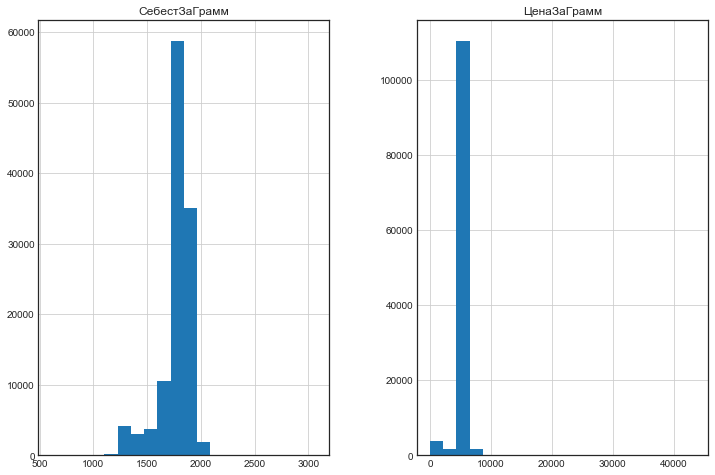

In [19]:

df.hist(column=['СебестЗаГрамм','ЦенаЗаГрамм'], bins=20, grid=True, figsize=(12, 8))


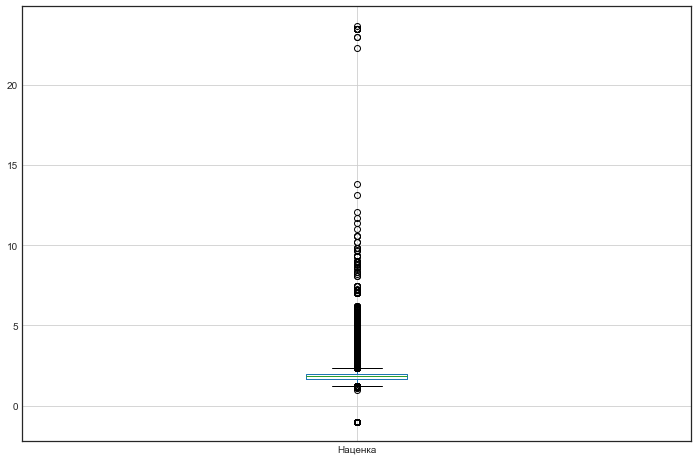

In [21]:
df.boxplot(column='Наценка', figsize=(12, 8))

In [22]:
df.describe()

,ЧистыйВес,СуммаРеализации,СуммаПрихода,Наценка,СебестЗаГрамм,ЦенаЗаГрамм
count,117638.000000,117638.00000,117638.000000,117638.000000,117638.000000,117638.000000
mean,1.590155,7584.91144,2766.891971,1.767782,1767.506231,4864.216019
std,0.975153,4655.11922,1652.626190,0.656909,143.882869,1138.867499
min,0.120000,0.00000,353.650000,-1.000000,611.000000,0.000000
25%,0.870000,4388.00000,1576.825000,1.654428,1736.000000,4561.000000
50%,1.260000,6160.00000,2251.950000,1.814685,1804.000000,4990.000000
75%,2.080000,10130.00000,3559.985000,1.937586,1850.000000,5217.000000
max,5.530000,39116.00000,10463.190000,23.676409,3072.000000,43426.000000


In [27]:
(df.Наценка < 1 ).sum()

3755

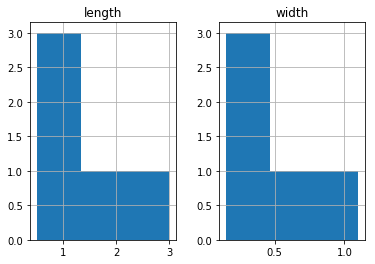

In [10]:
df = pd.DataFrame({
    'length': [1.5, 0.5, 1.2, 0.9, 3],
    'width': [0.7, 0.2, 0.15, 0.2, 1.1]
    }, index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])
hist = df.hist(bins=3)

In [47]:
import pandas as pd

df = pd.read_excel('C:/рушники/123.xlsx', skiprows=7, names=['tg', 'tov', 'ost'])

df = df.query('ost > 0')

bins = [1, 10, 30, 10000]
df['binned'] = pd.cut(df['ost'], bins, right=False)
df.drop(columns='ost', inplace=True)
result = df.groupby(by=['tg','binned']).count().unstack()

result.to_excel('C:/рушники/12.xlsx')


In [37]:
df['tg'].value_counts().to_excel('C:/рушники/122.xlsx')

In [45]:
df.groupby(by=['binned', 'tg']).count().unstack()

tov                                             \
tg          БК КОЛЬЦА БК КОЛЬЦА ОБРУЧ БК ПЕЧАТКИ БК ПОДВЕС ДЕКОР   
binned                                                             
[1, 10)         162.0           931.0        NaN           109.0   
[10, 30)         37.0           838.0        1.0            13.0   
[30, 10000)     362.0          1162.0      107.0           175.0   

                                                                            \
tg          БК ПОДВЕС КУЛЬТ БК СЕРЬГИ ИФ КОЛЬЦА ИФ КОЛЬЦА ОБРУЧ ИФ ПЕЧАТКИ   
binned                                                                       
[1, 10)                46.0     363.0    2328.0           123.0       29.0   
[10, 30)               38.0     131.0    1005.0           150.0       77.0   
[30, 10000)           461.0     475.0    1797.0           268.0      174.0   

                                                       
tg          ИФ ПОДВЕС ДЕКОР ИФ ПОДВЕС КУЛЬТ ИФ СЕРЬГИ  
binned                                                 
[1, 10)               181.0            31.0     428.0  
[10, 30)               58.0             4.0      99.0  
[30, 10000)           540.0           142.0     745.0